# Time-Temperature Water Mastercurve

Auto-TTS on time-temp water oscillatory sweeps.

**Data:** examples/data/pyRheo/time-temp-water/ttw_*_*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 17:24:49,766:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load multi-temperature sweeps

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'time-temp-water'
files = [p for p in DATA_DIR.glob('ttw_*_*.csv') if p.is_file()]

datasets = []
for fpath in sorted(files):
    parts = fpath.stem.split('_')
    temp_c = float(parts[1])
    df = pd.read_csv(fpath)
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df['Angular Frequency'] = pd.to_numeric(df['Angular Frequency'], errors='coerce')
    df['Storage Modulus'] = pd.to_numeric(df['Storage Modulus'], errors='coerce')
    df['Loss Modulus'] = pd.to_numeric(df['Loss Modulus'], errors='coerce')
    df = df.dropna()
    omega = df['Angular Frequency'].to_numpy()
    Gp = df['Storage Modulus'].to_numpy()
    Gpp = df['Loss Modulus'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15}))

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.251994s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1252 | final_cost=1.005028e-04 | time=3.252s | final_gradient_norm=0.007251767518970865


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.571761s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1267 | final_cost=7.315456e-05 | time=2.572s | final_gradient_norm=0.006310429558402864


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.416639s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1255 | final_cost=1.320568e-04 | time=2.417s | final_gradient_norm=0.008538177595948092


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.631170s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1308 | final_cost=6.064903e-05 | time=2.631s | final_gradient_norm=0.30814766161398094


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.648948s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=751 | final_cost=5.010735e-04 | time=1.649s | final_gradient_norm=0.010154740740319574


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.750566s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=817 | final_cost=2.754774e-04 | time=1.751s | final_gradient_norm=0.008096812091738693


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.490102s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=651 | final_cost=6.474603e-04 | time=1.490s | final_gradient_norm=2.018641451300891


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.561494s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=691 | final_cost=6.473377e-04 | time=1.561s | final_gradient_norm=40.94054060656885


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.465392s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=681 | final_cost=6.380344e-04 | time=1.465s | final_gradient_norm=0.5215847612634149


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.511830s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=659 | final_cost=5.715928e-04 | time=1.512s | final_gradient_norm=1.013604692103007


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.340392s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=93 | final_cost=2.350862e-04 | time=0.340s | final_gradient_norm=0.017428473402252523


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.933458s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=908 | final_cost=2.215488e-04 | time=1.933s | final_gradient_norm=0.39856216239560405


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.389774s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=657 | final_cost=5.707327e-04 | time=1.390s | final_gradient_norm=0.40739212172876194


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.334036s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=623 | final_cost=5.694603e-04 | time=1.334s | final_gradient_norm=0.4561131151193062


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.291039s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=65 | final_cost=3.128697e-04 | time=0.291s | final_gradient_norm=0.00022683302584751577


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.280489s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=63 | final_cost=3.127569e-04 | time=0.280s | final_gradient_norm=5.7051737160233835e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.819290s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=954 | final_cost=5.755286e-04 | time=1.819s | final_gradient_norm=0.10753859987115626


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.998354s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=850 | final_cost=3.007907e-04 | time=1.998s | final_gradient_norm=0.01995309482722051


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.141751s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=951 | final_cost=3.257798e-04 | time=2.142s | final_gradient_norm=0.1118927436623495


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.058803s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=861 | final_cost=2.593163e-04 | time=2.059s | final_gradient_norm=0.014530727826460343


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.250562s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=964 | final_cost=3.175652e-04 | time=2.251s | final_gradient_norm=0.2584616339863477


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.218073s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=942 | final_cost=3.173863e-04 | time=2.218s | final_gradient_norm=0.0104634992368039


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.426179s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1035 | final_cost=1.650887e-04 | time=2.426s | final_gradient_norm=0.004839004352861976


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.357485s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1013 | final_cost=1.537305e-04 | time=2.357s | final_gradient_norm=0.00528488241477517


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.013767s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=927 | final_cost=9.929661e-05 | time=2.014s | final_gradient_norm=0.0064580686482788


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.948506s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=921 | final_cost=7.889665e-05 | time=1.949s | final_gradient_norm=0.007410462887506789


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.220070s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=6.257285e-05 | time=0.220s | final_gradient_norm=3.482055805487306e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.370332s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=108 | final_cost=5.336247e-05 | time=0.370s | final_gradient_norm=0.6452123536507448


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.930586s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=998 | final_cost=4.078985e-04 | time=1.931s | final_gradient_norm=0.038587186612444965


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.637480s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=778 | final_cost=4.065538e-04 | time=1.637s | final_gradient_norm=0.017322529511965775


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.235739s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=37 | final_cost=3.639621e-04 | time=0.236s | final_gradient_norm=8.153180130330928e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.241177s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=3.620399e-04 | time=0.241s | final_gradient_norm=0.01823519007604298


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.328989s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1170 | final_cost=4.951001e-04 | time=2.329s | final_gradient_norm=0.015320160115081357


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.059614s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1054 | final_cost=4.821643e-04 | time=2.060s | final_gradient_norm=0.033612204979346985


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.988486s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1053 | final_cost=2.123763e-04 | time=1.988s | final_gradient_norm=0.05410019500028971


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.744006s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1484 | final_cost=3.486054e-05 | time=2.744s | final_gradient_norm=0.03526660515717509


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.211666s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=3.387986e-04 | time=0.212s | final_gradient_norm=0.000492442373986199


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.215604s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=2.997412e-04 | time=0.216s | final_gradient_norm=4.280037601382941e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.302055s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1671 | final_cost=1.480330e-04 | time=3.302s | final_gradient_norm=0.008180904057570089


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.119834s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1573 | final_cost=1.257570e-04 | time=3.120s | final_gradient_norm=0.016234675014021982


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.299416s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1222 | final_cost=2.683607e-04 | time=2.299s | final_gradient_norm=0.04575117164809914


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.817277s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=875 | final_cost=2.369519e-04 | time=1.817s | final_gradient_norm=0.023449069822161835


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.735708s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=846 | final_cost=4.639247e-04 | time=1.736s | final_gradient_norm=0.017219378435018688


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.923910s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=925 | final_cost=1.738802e-04 | time=1.924s | final_gradient_norm=0.015876663378453296


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.459582s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1220 | final_cost=1.683591e-04 | time=2.460s | final_gradient_norm=0.007030826659714836


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.531334s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1264 | final_cost=1.446726e-04 | time=2.531s | final_gradient_norm=0.047356328287100305


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.179151s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.322180e-03 | time=0.179s | final_gradient_norm=0.00036016999302856836


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.191014s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=8.392862e-04 | time=0.191s | final_gradient_norm=0.0009601934691620223


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.175302s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=1.828364e-03 | time=0.175s | final_gradient_norm=0.00033526108373405566


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180424s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=7.768045e-04 | time=0.180s | final_gradient_norm=2.3026937171076135e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.175748s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=7.338565e-04 | time=0.176s | final_gradient_norm=0.005731785508302066


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.176939s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=9 | final_cost=4.019186e-04 | time=0.177s | final_gradient_norm=6.418400083367461e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.267563s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=49 | final_cost=3.399393e-04 | time=0.268s | final_gradient_norm=0.0010303669018386181


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.219665s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=28 | final_cost=3.225811e-04 | time=0.220s | final_gradient_norm=3.1364246685663004e-07


Temps (C): [70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 85.0, 85.0, 85.0, 85.0, 85.0, 90.0, 90.0, 90.0, 90.0, 90.0, 95.0, 95.0, 95.0, 95.0]


## Plot raw vs shifted

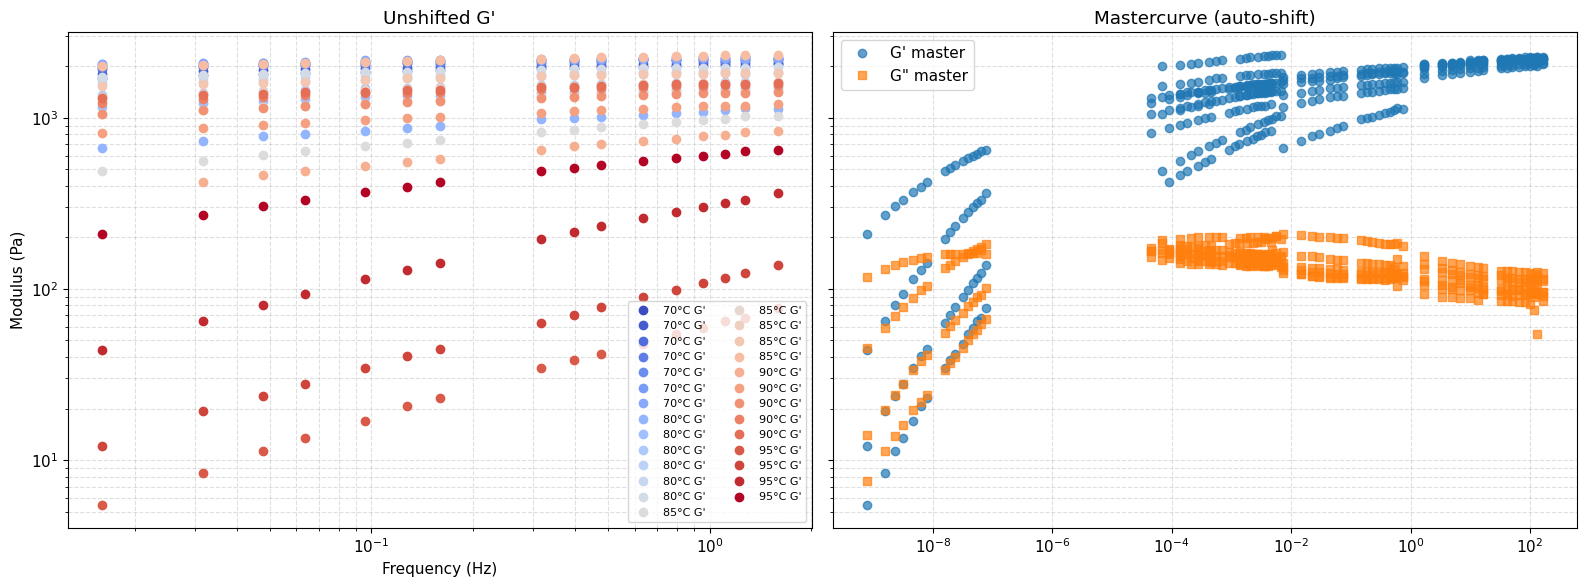

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.623033s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=2.145900e+07 | time=0.623s | final_gradient_norm=19411829.06980979


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.225157s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=2.145900e+07 | time=0.225s | final_gradient_norm=19411829.06980979


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.722774s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=2.162708e+07 | time=0.723s | final_gradient_norm=56869665220.91165


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.742075s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.208761e+07 | time=0.742s | final_gradient_norm=5895916388.419473


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.574055s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=2.499365e+07 | time=0.574s | final_gradient_norm=5233685948.190708


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.311710s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=79 | final_cost=4.294400e+07 | time=0.312s | final_gradient_norm=3209986.609154658


Element minimization: early termination at n_modes=1 (R²=0.842971 < threshold=0.882300)


Element minimization: reducing from 5 to 2 modes


Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.041530s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=54 | final_cost=4.692491e+01 | time=1.042s | final_gradient_norm=16.797543698782054


{'gm_r2': 0.7422342012487237, 'fm_r2': 0.6653660649299127}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.466591s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=3.469342e+03 | time=0.467s | final_gradient_norm=3.107338749993338


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.247542s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=3.469342e+03 | time=0.248s | final_gradient_norm=3.107338749993338


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.189858s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=3.790934e+04 | time=0.190s | final_gradient_norm=84442771.23833059


Element minimization: early termination at n_modes=1 (R²=0.930405 < threshold=0.990446)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.328271s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=1.222337e-03 | time=0.328s | final_gradient_norm=0.00015236830486870095


Model ranking (R²): [('fm', 0.999), ('gm', 0.977)]


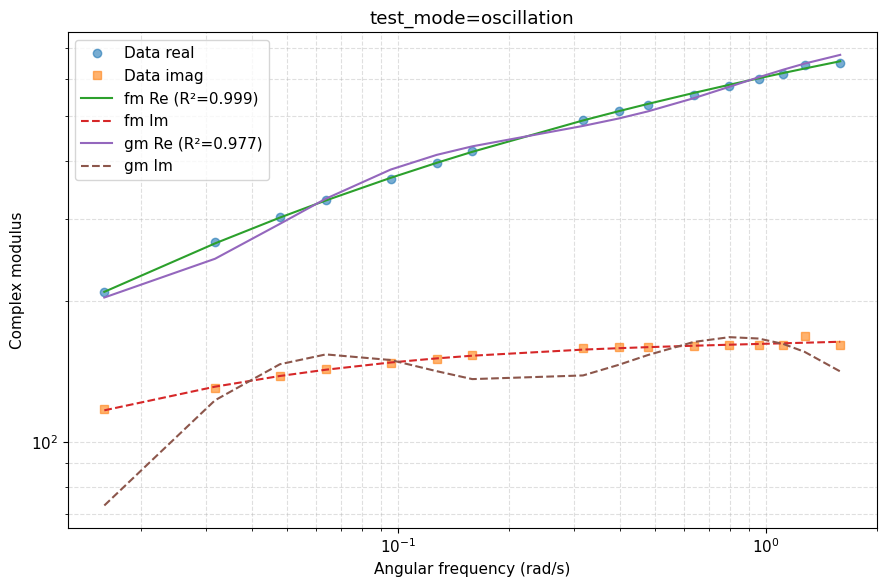

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<47:08,  1.41it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 55/4000 [00:00<00:42, 91.76it/s, 255 steps of size 1.05e-03. acc. prob=0.73]

warmup:   3%|▎         | 127/4000 [00:00<00:18, 212.89it/s, 511 steps of size 1.49e-02. acc. prob=0.76]

warmup:   6%|▌         | 224/4000 [00:01<00:10, 376.52it/s, 255 steps of size 1.78e-02. acc. prob=0.77]

warmup:   8%|▊         | 302/4000 [00:01<00:07, 470.74it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  10%|▉         | 396/4000 [00:01<00:06, 588.44it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  12%|█▏        | 492/4000 [00:01<00:05, 684.24it/s, 511 steps of size 2.55e-02. acc. prob=0.78]

warmup:  15%|█▌        | 601/4000 [00:01<00:04, 795.03it/s, 51 steps of size 2.73e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 737/4000 [00:01<00:03, 952.49it/s, 127 steps of size 1.58e-02. acc. prob=0.79]

warmup:  22%|██▏       | 875/4000 [00:01<00:02, 1074.33it/s, 31 steps of size 1.51e-02. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [00:01<00:02, 1088.56it/s, 31 steps of size 6.22e-03. acc. prob=0.79]

sample:  28%|██▊       | 1106/4000 [00:01<00:02, 1066.76it/s, 511 steps of size 1.56e-02. acc. prob=0.91]

sample:  30%|███       | 1217/4000 [00:01<00:02, 1073.32it/s, 71 steps of size 1.56e-02. acc. prob=0.92] 

sample:  33%|███▎      | 1337/4000 [00:02<00:02, 1106.40it/s, 271 steps of size 1.56e-02. acc. prob=0.92]

sample:  36%|███▋      | 1451/4000 [00:02<00:02, 1115.53it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  39%|███▉      | 1565/4000 [00:02<00:02, 1117.34it/s, 63 steps of size 1.56e-02. acc. prob=0.92] 

sample:  42%|████▏     | 1678/4000 [00:02<00:02, 1118.87it/s, 127 steps of size 1.56e-02. acc. prob=0.92]

sample:  45%|████▍     | 1791/4000 [00:02<00:01, 1121.74it/s, 87 steps of size 1.56e-02. acc. prob=0.92] 

sample:  48%|████▊     | 1904/4000 [00:02<00:01, 1113.28it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  50%|█████     | 2016/4000 [00:02<00:01, 1101.12it/s, 7 steps of size 1.56e-02. acc. prob=0.92]  

sample:  53%|█████▎    | 2129/4000 [00:02<00:01, 1109.48it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  56%|█████▌    | 2244/4000 [00:02<00:01, 1119.39it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2357/4000 [00:02<00:01, 1122.23it/s, 87 steps of size 1.56e-02. acc. prob=0.92] 

sample:  62%|██████▏   | 2472/4000 [00:03<00:01, 1127.69it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  65%|██████▍   | 2585/4000 [00:03<00:01, 1109.47it/s, 135 steps of size 1.56e-02. acc. prob=0.92]

sample:  67%|██████▋   | 2697/4000 [00:03<00:01, 1099.14it/s, 119 steps of size 1.56e-02. acc. prob=0.92]

sample:  71%|███████   | 2826/4000 [00:03<00:01, 1152.96it/s, 127 steps of size 1.56e-02. acc. prob=0.92]

sample:  74%|███████▎  | 2942/4000 [00:03<00:00, 1139.50it/s, 55 steps of size 1.56e-02. acc. prob=0.92] 

sample:  76%|███████▋  | 3057/4000 [00:03<00:00, 1119.74it/s, 7 steps of size 1.56e-02. acc. prob=0.92] 

sample:  79%|███████▉  | 3170/4000 [00:03<00:00, 1120.01it/s, 383 steps of size 1.56e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3283/4000 [00:03<00:00, 1112.69it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  85%|████████▍ | 3395/4000 [00:03<00:00, 1110.30it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3507/4000 [00:03<00:00, 1076.77it/s, 383 steps of size 1.56e-02. acc. prob=0.92]

sample:  90%|█████████ | 3616/4000 [00:04<00:00, 1080.36it/s, 511 steps of size 1.56e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3727/4000 [00:04<00:00, 1087.75it/s, 287 steps of size 1.56e-02. acc. prob=0.92]

sample:  96%|█████████▋| 3855/4000 [00:04<00:00, 1140.31it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample:  99%|█████████▉| 3970/4000 [00:04<00:00, 1110.40it/s, 255 steps of size 1.56e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 905.14it/s, 63 steps of size 1.56e-02. acc. prob=0.92]  

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 74/4000 [00:00<00:05, 738.43it/s, 511 steps of size 2.23e-03. acc. prob=0.74]

warmup:   4%|▍         | 160/4000 [00:00<00:04, 808.32it/s, 33 steps of size 3.08e-03. acc. prob=0.76]

warmup:   7%|▋         | 262/4000 [00:00<00:04, 903.38it/s, 255 steps of size 2.04e-02. acc. prob=0.77]

warmup:   9%|▉         | 353/4000 [00:00<00:04, 871.10it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  11%|█         | 443/4000 [00:00<00:04, 878.93it/s, 511 steps of size 7.23e-03. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [00:00<00:03, 923.96it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  17%|█▋        | 670/4000 [00:00<00:03, 1027.33it/s, 127 steps of size 2.16e-02. acc. prob=0.79]

warmup:  20%|█▉        | 789/4000 [00:00<00:02, 1078.00it/s, 383 steps of size 2.14e-02. acc. prob=0.79]

warmup:  23%|██▎       | 926/4000 [00:00<00:02, 1164.59it/s, 255 steps of size 1.81e-02. acc. prob=0.79]

sample:  26%|██▌       | 1043/4000 [00:01<00:02, 1158.26it/s, 119 steps of size 1.48e-02. acc. prob=0.87]

sample:  29%|██▉       | 1159/4000 [00:01<00:02, 1125.74it/s, 47 steps of size 1.48e-02. acc. prob=0.90] 

sample:  32%|███▏      | 1272/4000 [00:01<00:02, 1099.75it/s, 55 steps of size 1.48e-02. acc. prob=0.91]

sample:  35%|███▍      | 1390/4000 [00:01<00:02, 1122.90it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  38%|███▊      | 1504/4000 [00:01<00:02, 1124.95it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  40%|████      | 1617/4000 [00:01<00:02, 1104.31it/s, 63 steps of size 1.48e-02. acc. prob=0.91] 

sample:  43%|████▎     | 1730/4000 [00:01<00:02, 1111.19it/s, 63 steps of size 1.48e-02. acc. prob=0.91]

sample:  46%|████▌     | 1842/4000 [00:01<00:01, 1108.21it/s, 7 steps of size 1.48e-02. acc. prob=0.91] 

sample:  49%|████▉     | 1954/4000 [00:01<00:01, 1108.82it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  52%|█████▏    | 2068/4000 [00:01<00:01, 1116.89it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  55%|█████▍    | 2180/4000 [00:02<00:01, 1109.34it/s, 383 steps of size 1.48e-02. acc. prob=0.91]

sample:  57%|█████▋    | 2296/4000 [00:02<00:01, 1117.76it/s, 511 steps of size 1.48e-02. acc. prob=0.91]

sample:  60%|██████    | 2418/4000 [00:02<00:01, 1144.89it/s, 291 steps of size 1.48e-02. acc. prob=0.91]

sample:  63%|██████▎   | 2533/4000 [00:02<00:01, 1137.29it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  66%|██████▌   | 2647/4000 [00:02<00:01, 1109.26it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  69%|██████▉   | 2759/4000 [00:02<00:01, 1094.52it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  72%|███████▏  | 2869/4000 [00:02<00:01, 1092.88it/s, 299 steps of size 1.48e-02. acc. prob=0.91]

sample:  74%|███████▍  | 2979/4000 [00:02<00:00, 1074.66it/s, 195 steps of size 1.48e-02. acc. prob=0.91]

sample:  77%|███████▋  | 3087/4000 [00:02<00:00, 1070.58it/s, 191 steps of size 1.48e-02. acc. prob=0.91]

sample:  80%|████████  | 3202/4000 [00:02<00:00, 1090.81it/s, 511 steps of size 1.48e-02. acc. prob=0.91]

sample:  83%|████████▎ | 3312/4000 [00:03<00:00, 1087.17it/s, 383 steps of size 1.48e-02. acc. prob=0.91]

sample:  86%|████████▌ | 3421/4000 [00:03<00:00, 1072.92it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  88%|████████▊ | 3529/4000 [00:03<00:00, 1072.01it/s, 383 steps of size 1.48e-02. acc. prob=0.91]

sample:  91%|█████████ | 3642/4000 [00:03<00:00, 1087.09it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  94%|█████████▍| 3754/4000 [00:03<00:00, 1094.64it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

sample:  97%|█████████▋| 3876/4000 [00:03<00:00, 1130.85it/s, 63 steps of size 1.48e-02. acc. prob=0.91] 

sample: 100%|█████████▉| 3990/4000 [00:03<00:00, 1126.25it/s, 47 steps of size 1.48e-02. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1081.44it/s, 255 steps of size 1.48e-02. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 60/4000 [00:00<00:06, 593.81it/s, 1023 steps of size 9.39e-04. acc. prob=0.73]

warmup:   3%|▎         | 130/4000 [00:00<00:05, 652.83it/s, 1023 steps of size 7.87e-03. acc. prob=0.76]

warmup:   6%|▌         | 229/4000 [00:00<00:04, 798.74it/s, 511 steps of size 2.28e-02. acc. prob=0.77] 

warmup:   8%|▊         | 324/4000 [00:00<00:04, 856.81it/s, 127 steps of size 1.47e-02. acc. prob=0.78]

warmup:  11%|█         | 428/4000 [00:00<00:03, 922.34it/s, 12 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 522/4000 [00:00<00:03, 922.62it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  16%|█▌        | 648/4000 [00:00<00:03, 1030.84it/s, 191 steps of size 1.93e-02. acc. prob=0.79]

warmup:  20%|█▉        | 789/4000 [00:00<00:02, 1147.28it/s, 255 steps of size 2.28e-02. acc. prob=0.79]

warmup:  23%|██▎       | 927/4000 [00:00<00:02, 1219.05it/s, 79 steps of size 2.83e-02. acc. prob=0.79] 

sample:  26%|██▌       | 1049/4000 [00:01<00:02, 1108.61it/s, 63 steps of size 1.17e-02. acc. prob=0.91]

sample:  29%|██▉       | 1162/4000 [00:01<00:02, 1054.55it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  32%|███▏      | 1270/4000 [00:01<00:02, 1027.95it/s, 511 steps of size 1.17e-02. acc. prob=0.92]

sample:  34%|███▍      | 1374/4000 [00:01<00:02, 1023.01it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  37%|███▋      | 1478/4000 [00:01<00:02, 995.60it/s, 127 steps of size 1.17e-02. acc. prob=0.92] 

sample:  39%|███▉      | 1579/4000 [00:01<00:02, 955.19it/s, 3 steps of size 1.17e-02. acc. prob=0.92]  

sample:  42%|████▏     | 1676/4000 [00:01<00:02, 949.34it/s, 303 steps of size 1.17e-02. acc. prob=0.92]

sample:  45%|████▍     | 1781/4000 [00:01<00:02, 974.70it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  47%|████▋     | 1879/4000 [00:01<00:02, 964.29it/s, 31 steps of size 1.17e-02. acc. prob=0.92] 

sample:  49%|████▉     | 1976/4000 [00:02<00:02, 954.15it/s, 383 steps of size 1.17e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2073/4000 [00:02<00:02, 958.57it/s, 239 steps of size 1.17e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2176/4000 [00:02<00:01, 977.22it/s, 247 steps of size 1.17e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2283/4000 [00:02<00:01, 1002.79it/s, 319 steps of size 1.17e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2384/4000 [00:02<00:01, 983.96it/s, 383 steps of size 1.17e-02. acc. prob=0.92] 

sample:  62%|██████▏   | 2485/4000 [00:02<00:01, 991.21it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  65%|██████▍   | 2592/4000 [00:02<00:01, 1011.38it/s, 383 steps of size 1.17e-02. acc. prob=0.92]

sample:  67%|██████▋   | 2694/4000 [00:02<00:01, 1006.42it/s, 79 steps of size 1.17e-02. acc. prob=0.92] 

sample:  70%|███████   | 2802/4000 [00:02<00:01, 1024.66it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2909/4000 [00:02<00:01, 1036.82it/s, 127 steps of size 1.17e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3013/4000 [00:03<00:00, 1022.50it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3116/4000 [00:03<00:00, 1009.82it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  80%|████████  | 3218/4000 [00:03<00:00, 965.85it/s, 255 steps of size 1.17e-02. acc. prob=0.92] 

sample:  83%|████████▎ | 3315/4000 [00:03<00:00, 958.67it/s, 383 steps of size 1.17e-02. acc. prob=0.92]

sample:  85%|████████▌ | 3412/4000 [00:03<00:00, 953.53it/s, 31 steps of size 1.17e-02. acc. prob=0.92] 

sample:  88%|████████▊ | 3508/4000 [00:03<00:00, 946.19it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  90%|█████████ | 3603/4000 [00:03<00:00, 940.03it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3701/4000 [00:03<00:00, 950.68it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample:  95%|█████████▌| 3801/4000 [00:03<00:00, 965.02it/s, 127 steps of size 1.17e-02. acc. prob=0.92]

sample:  97%|█████████▋| 3898/4000 [00:03<00:00, 942.55it/s, 511 steps of size 1.17e-02. acc. prob=0.92]

sample: 100%|█████████▉| 3999/4000 [00:04<00:00, 959.84it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 980.29it/s, 255 steps of size 1.17e-02. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 66/4000 [00:00<00:05, 659.49it/s, 7 steps of size 7.15e-04. acc. prob=0.73]

warmup:   4%|▎         | 142/4000 [00:00<00:05, 714.36it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:   6%|▌         | 229/4000 [00:00<00:04, 784.13it/s, 127 steps of size 2.29e-02. acc. prob=0.78]

warmup:   8%|▊         | 310/4000 [00:00<00:04, 793.53it/s, 255 steps of size 9.77e-03. acc. prob=0.78]

warmup:  10%|█         | 406/4000 [00:00<00:04, 852.14it/s, 83 steps of size 2.31e-02. acc. prob=0.78] 

warmup:  12%|█▎        | 500/4000 [00:00<00:03, 876.81it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [00:00<00:03, 928.42it/s, 443 steps of size 1.59e-02. acc. prob=0.78]

warmup:  18%|█▊        | 727/4000 [00:00<00:03, 1018.76it/s, 127 steps of size 2.01e-02. acc. prob=0.79]

warmup:  21%|██        | 848/4000 [00:00<00:02, 1077.45it/s, 103 steps of size 3.27e-02. acc. prob=0.79]

warmup:  24%|██▍       | 972/4000 [00:01<00:02, 1124.87it/s, 255 steps of size 2.29e-02. acc. prob=0.79]

sample:  27%|██▋       | 1085/4000 [00:01<00:02, 1071.12it/s, 191 steps of size 1.51e-02. acc. prob=0.94]

sample:  30%|██▉       | 1194/4000 [00:01<00:02, 1076.17it/s, 511 steps of size 1.51e-02. acc. prob=0.93]

sample:  33%|███▎      | 1303/4000 [00:01<00:02, 1033.90it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  35%|███▌      | 1407/4000 [00:01<00:02, 1033.90it/s, 127 steps of size 1.51e-02. acc. prob=0.93]

sample:  38%|███▊      | 1511/4000 [00:01<00:02, 1031.98it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  40%|████      | 1615/4000 [00:01<00:02, 1028.49it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  43%|████▎     | 1719/4000 [00:01<00:02, 1021.63it/s, 15 steps of size 1.51e-02. acc. prob=0.93] 

sample:  46%|████▌     | 1835/4000 [00:01<00:02, 1059.95it/s, 127 steps of size 1.51e-02. acc. prob=0.93]

sample:  49%|████▊     | 1942/4000 [00:01<00:02, 1023.03it/s, 375 steps of size 1.51e-02. acc. prob=0.93]

sample:  51%|█████▏    | 2055/4000 [00:02<00:01, 1051.54it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2161/4000 [00:02<00:01, 1008.21it/s, 383 steps of size 1.51e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2264/4000 [00:02<00:01, 1012.69it/s, 511 steps of size 1.51e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2368/4000 [00:02<00:01, 1015.24it/s, 511 steps of size 1.51e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2470/4000 [00:02<00:01, 1001.24it/s, 199 steps of size 1.51e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2571/4000 [00:02<00:01, 999.10it/s, 511 steps of size 1.51e-02. acc. prob=0.93] 

sample:  67%|██████▋   | 2672/4000 [00:02<00:01, 996.65it/s, 127 steps of size 1.51e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2785/4000 [00:02<00:01, 1035.31it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2890/4000 [00:02<00:01, 1036.98it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2994/4000 [00:02<00:00, 1033.73it/s, 127 steps of size 1.51e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3106/4000 [00:03<00:00, 1058.89it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  80%|████████  | 3213/4000 [00:03<00:00, 1059.61it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3326/4000 [00:03<00:00, 1076.92it/s, 303 steps of size 1.51e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3444/4000 [00:03<00:00, 1106.53it/s, 87 steps of size 1.51e-02. acc. prob=0.93] 

sample:  89%|████████▉ | 3555/4000 [00:03<00:00, 1069.20it/s, 447 steps of size 1.51e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3668/4000 [00:03<00:00, 1086.52it/s, 255 steps of size 1.51e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3777/4000 [00:03<00:00, 1076.31it/s, 79 steps of size 1.51e-02. acc. prob=0.93] 

sample:  97%|█████████▋| 3885/4000 [00:03<00:00, 1047.16it/s, 51 steps of size 1.51e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3995/4000 [00:03<00:00, 1056.63it/s, 511 steps of size 1.51e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1018.92it/s, 95 steps of size 1.51e-02. acc. prob=0.93] 

array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'c1\n0'}>,
        <Axes: title={'center': 'c1\n1'}>,
        <Axes: title={'center': 'c1\n2'}>,
        <Axes: title={'center': 'c1\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau\n0'}>,
       

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.206475s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=2.499366e+07 | time=0.206s | final_gradient_norm=10292630816.087831


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.209806s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=2.499366e+07 | time=0.210s | final_gradient_norm=10292630816.087831


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.332988s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=79 | final_cost=4.294400e+07 | time=0.333s | final_gradient_norm=3213388.0131458226


Element minimization: early termination at n_modes=1 (R²=0.842971 < threshold=0.862912)


Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.399900s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=54 | final_cost=4.692491e+01 | time=0.400s | final_gradient_norm=16.797543698782054


Model ranking (R²): [('gm', 0.742), ('fm', 0.665)]


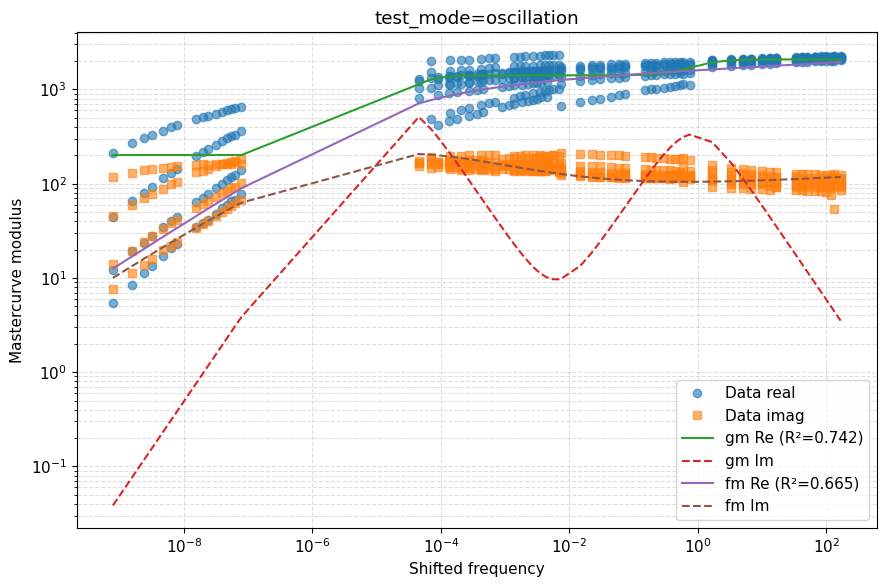

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<44:32,  1.50it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   2%|▏         | 66/4000 [00:00<00:34, 115.69it/s, 31 steps of size 2.06e-02. acc. prob=0.76]

warmup:   4%|▍         | 154/4000 [00:00<00:14, 268.66it/s, 127 steps of size 2.34e-02. acc. prob=0.77]

warmup:   5%|▌         | 215/4000 [00:01<00:14, 265.75it/s, 383 steps of size 1.53e-02. acc. prob=0.77]

warmup:   7%|▋         | 262/4000 [00:01<00:13, 277.84it/s, 127 steps of size 5.90e-02. acc. prob=0.78]

warmup:   8%|▊         | 304/4000 [00:01<00:12, 287.12it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:   9%|▊         | 345/4000 [00:01<00:11, 312.67it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  10%|▉         | 391/4000 [00:01<00:10, 346.40it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [00:01<00:09, 372.56it/s, 383 steps of size 1.70e-02. acc. prob=0.78]

warmup:  12%|█▏        | 481/4000 [00:01<00:10, 334.42it/s, 3 steps of size 1.50e-02. acc. prob=0.78]  

warmup:  13%|█▎        | 519/4000 [00:01<00:10, 336.40it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  14%|█▍        | 556/4000 [00:02<00:10, 344.19it/s, 127 steps of size 2.18e-02. acc. prob=0.78]

warmup:  15%|█▍        | 599/4000 [00:02<00:09, 366.37it/s, 63 steps of size 2.77e-02. acc. prob=0.79] 

warmup:  16%|█▌        | 641/4000 [00:02<00:08, 380.82it/s, 127 steps of size 2.94e-02. acc. prob=0.79]

warmup:  17%|█▋        | 686/4000 [00:02<00:08, 399.04it/s, 127 steps of size 1.37e-02. acc. prob=0.79]

warmup:  18%|█▊        | 727/4000 [00:02<00:08, 395.86it/s, 127 steps of size 2.20e-02. acc. prob=0.79]

warmup:  19%|█▉        | 768/4000 [00:02<00:08, 389.09it/s, 239 steps of size 2.55e-02. acc. prob=0.79]

warmup:  20%|██        | 815/4000 [00:02<00:07, 407.71it/s, 255 steps of size 2.76e-02. acc. prob=0.79]

warmup:  21%|██▏       | 859/4000 [00:02<00:07, 415.40it/s, 63 steps of size 3.18e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 901/4000 [00:02<00:07, 407.95it/s, 255 steps of size 2.61e-02. acc. prob=0.79]

warmup:  24%|██▎       | 948/4000 [00:03<00:07, 422.75it/s, 255 steps of size 2.18e-02. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [00:03<00:08, 362.52it/s, 127 steps of size 2.99e-02. acc. prob=0.79]

sample:  26%|██▌       | 1029/4000 [00:03<00:08, 339.15it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  27%|██▋       | 1065/4000 [00:03<00:08, 334.65it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  28%|██▊       | 1100/4000 [00:03<00:08, 322.95it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  28%|██▊       | 1133/4000 [00:03<00:09, 314.92it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  29%|██▉       | 1165/4000 [00:03<00:09, 302.13it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  30%|██▉       | 1197/4000 [00:03<00:09, 304.85it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  31%|███       | 1228/4000 [00:03<00:09, 298.18it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  32%|███▏      | 1261/4000 [00:04<00:09, 303.57it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  32%|███▏      | 1292/4000 [00:04<00:09, 296.53it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  33%|███▎      | 1322/4000 [00:04<00:09, 292.04it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  34%|███▍      | 1353/4000 [00:04<00:08, 295.72it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  35%|███▍      | 1385/4000 [00:04<00:08, 301.07it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  35%|███▌      | 1416/4000 [00:04<00:08, 296.27it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  36%|███▌      | 1446/4000 [00:04<00:08, 292.46it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  37%|███▋      | 1476/4000 [00:04<00:08, 282.98it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  38%|███▊      | 1507/4000 [00:04<00:08, 290.61it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  39%|███▊      | 1542/4000 [00:05<00:08, 304.45it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  39%|███▉      | 1574/4000 [00:05<00:07, 306.74it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  40%|████      | 1605/4000 [00:05<00:07, 304.82it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  41%|████      | 1637/4000 [00:05<00:07, 308.70it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  42%|████▏     | 1668/4000 [00:05<00:07, 307.78it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  42%|████▏     | 1699/4000 [00:05<00:07, 303.80it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  43%|████▎     | 1730/4000 [00:05<00:07, 299.39it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  44%|████▍     | 1760/4000 [00:05<00:07, 291.59it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  45%|████▍     | 1790/4000 [00:05<00:07, 291.09it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  46%|████▌     | 1821/4000 [00:05<00:07, 294.50it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  46%|████▋     | 1851/4000 [00:06<00:07, 285.65it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  47%|████▋     | 1883/4000 [00:06<00:07, 294.15it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  48%|████▊     | 1916/4000 [00:06<00:06, 302.60it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  49%|████▊     | 1947/4000 [00:06<00:06, 294.28it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  49%|████▉     | 1977/4000 [00:06<00:06, 295.90it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  50%|█████     | 2007/4000 [00:06<00:07, 283.29it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  51%|█████     | 2037/4000 [00:06<00:06, 284.95it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2066/4000 [00:06<00:06, 282.17it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2097/4000 [00:06<00:06, 288.31it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2128/4000 [00:07<00:06, 292.83it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  54%|█████▍    | 2158/4000 [00:07<00:06, 286.87it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  55%|█████▍    | 2187/4000 [00:07<00:06, 281.40it/s, 159 steps of size 1.86e-02. acc. prob=0.96]

sample:  55%|█████▌    | 2218/4000 [00:07<00:06, 287.63it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2247/4000 [00:07<00:06, 276.30it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2277/4000 [00:07<00:06, 281.35it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2308/4000 [00:07<00:05, 289.22it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2339/4000 [00:07<00:05, 294.20it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  59%|█████▉    | 2370/4000 [00:07<00:05, 296.83it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  60%|██████    | 2400/4000 [00:07<00:05, 291.60it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  61%|██████    | 2435/4000 [00:08<00:05, 304.73it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2466/4000 [00:08<00:05, 301.48it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2497/4000 [00:08<00:04, 301.25it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2528/4000 [00:08<00:04, 303.22it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2559/4000 [00:08<00:04, 295.09it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  65%|██████▍   | 2589/4000 [00:08<00:04, 296.26it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  66%|██████▌   | 2621/4000 [00:08<00:04, 301.35it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  66%|██████▋   | 2653/4000 [00:08<00:04, 306.24it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2684/4000 [00:08<00:04, 296.31it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  68%|██████▊   | 2717/4000 [00:09<00:04, 304.82it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  69%|██████▊   | 2748/4000 [00:09<00:04, 305.65it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  70%|██████▉   | 2780/4000 [00:09<00:03, 306.30it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  70%|███████   | 2811/4000 [00:09<00:04, 296.24it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  71%|███████   | 2841/4000 [00:09<00:03, 297.09it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2871/4000 [00:09<00:03, 292.28it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2901/4000 [00:09<00:03, 289.28it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2931/4000 [00:09<00:03, 291.72it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  74%|███████▍  | 2961/4000 [00:09<00:03, 283.90it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  75%|███████▍  | 2990/4000 [00:09<00:03, 274.71it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  76%|███████▌  | 3021/4000 [00:10<00:03, 283.06it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  76%|███████▋  | 3050/4000 [00:10<00:03, 278.94it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  77%|███████▋  | 3079/4000 [00:10<00:03, 281.70it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  78%|███████▊  | 3108/4000 [00:10<00:03, 278.35it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  79%|███████▊  | 3141/4000 [00:10<00:02, 290.26it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  79%|███████▉  | 3171/4000 [00:10<00:02, 290.71it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  80%|████████  | 3204/4000 [00:10<00:02, 300.54it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  81%|████████  | 3235/4000 [00:10<00:02, 301.53it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3266/4000 [00:10<00:02, 302.09it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3297/4000 [00:10<00:02, 299.19it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  83%|████████▎ | 3327/4000 [00:11<00:02, 293.64it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  84%|████████▍ | 3357/4000 [00:11<00:02, 287.13it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  85%|████████▍ | 3389/4000 [00:11<00:02, 294.46it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  85%|████████▌ | 3419/4000 [00:11<00:02, 285.73it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  86%|████████▌ | 3448/4000 [00:11<00:01, 286.67it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  87%|████████▋ | 3478/4000 [00:11<00:01, 288.38it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3507/4000 [00:11<00:01, 286.54it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3539/4000 [00:11<00:01, 295.31it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  89%|████████▉ | 3571/4000 [00:11<00:01, 300.65it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  90%|█████████ | 3602/4000 [00:12<00:01, 300.71it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  91%|█████████ | 3633/4000 [00:12<00:01, 301.70it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3667/4000 [00:12<00:01, 310.11it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3699/4000 [00:12<00:01, 294.80it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  93%|█████████▎| 3729/4000 [00:12<00:00, 287.94it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  94%|█████████▍| 3761/4000 [00:12<00:00, 295.47it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  95%|█████████▍| 3793/4000 [00:12<00:00, 300.75it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  96%|█████████▌| 3825/4000 [00:12<00:00, 304.88it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  96%|█████████▋| 3857/4000 [00:12<00:00, 306.04it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  97%|█████████▋| 3888/4000 [00:13<00:00, 295.66it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  98%|█████████▊| 3918/4000 [00:13<00:00, 290.46it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  99%|█████████▊| 3948/4000 [00:13<00:00, 292.89it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample: 100%|█████████▉| 3980/4000 [00:13<00:00, 299.89it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:13<00:00, 298.81it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 88/4000 [00:00<00:04, 878.13it/s, 7 steps of size 3.13e-02. acc. prob=0.77]

warmup:   4%|▍         | 176/4000 [00:00<00:07, 501.32it/s, 63 steps of size 1.01e-01. acc. prob=0.77]

warmup:   6%|▌         | 235/4000 [00:00<00:07, 485.97it/s, 127 steps of size 4.68e-02. acc. prob=0.78]

warmup:   7%|▋         | 289/4000 [00:00<00:08, 429.72it/s, 3 steps of size 4.95e-03. acc. prob=0.78]  

warmup:   8%|▊         | 335/4000 [00:00<00:09, 400.10it/s, 31 steps of size 4.33e-02. acc. prob=0.78]

warmup:   9%|▉         | 377/4000 [00:00<00:09, 395.71it/s, 127 steps of size 2.60e-02. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [00:00<00:08, 398.35it/s, 15 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  11%|█▏        | 459/4000 [00:01<00:08, 396.99it/s, 127 steps of size 4.07e-02. acc. prob=0.78]

warmup:  12%|█▎        | 500/4000 [00:01<00:10, 325.04it/s, 511 steps of size 1.95e-02. acc. prob=0.78]

warmup:  13%|█▎        | 536/4000 [00:01<00:10, 332.19it/s, 127 steps of size 3.98e-02. acc. prob=0.78]

warmup:  14%|█▍        | 573/4000 [00:01<00:10, 341.54it/s, 63 steps of size 4.72e-02. acc. prob=0.79] 

warmup:  15%|█▌        | 614/4000 [00:01<00:09, 359.84it/s, 255 steps of size 2.00e-02. acc. prob=0.79]

warmup:  16%|█▋        | 659/4000 [00:01<00:08, 382.48it/s, 255 steps of size 2.81e-02. acc. prob=0.79]

warmup:  18%|█▊        | 706/4000 [00:01<00:08, 402.82it/s, 255 steps of size 3.41e-02. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:01<00:08, 398.20it/s, 127 steps of size 2.30e-02. acc. prob=0.79]

warmup:  20%|█▉        | 795/4000 [00:01<00:07, 417.71it/s, 255 steps of size 2.38e-02. acc. prob=0.79]

warmup:  21%|██        | 841/4000 [00:02<00:07, 428.46it/s, 63 steps of size 3.60e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 895/4000 [00:02<00:06, 456.87it/s, 191 steps of size 2.35e-02. acc. prob=0.79]

warmup:  24%|██▎       | 942/4000 [00:02<00:06, 460.33it/s, 63 steps of size 3.53e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 989/4000 [00:02<00:08, 373.50it/s, 179 steps of size 2.72e-02. acc. prob=0.79]

sample:  26%|██▌       | 1030/4000 [00:02<00:09, 317.81it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  27%|██▋       | 1065/4000 [00:02<00:09, 307.40it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  27%|██▋       | 1098/4000 [00:02<00:09, 298.56it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  28%|██▊       | 1130/4000 [00:02<00:09, 300.91it/s, 63 steps of size 1.84e-02. acc. prob=0.95] 

sample:  29%|██▉       | 1162/4000 [00:03<00:09, 295.41it/s, 191 steps of size 1.84e-02. acc. prob=0.95]

sample:  30%|██▉       | 1193/4000 [00:03<00:09, 282.32it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  31%|███       | 1222/4000 [00:03<00:09, 284.22it/s, 127 steps of size 1.84e-02. acc. prob=0.95]

sample:  31%|███▏      | 1252/4000 [00:03<00:09, 286.09it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  32%|███▏      | 1281/4000 [00:03<00:09, 286.03it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  33%|███▎      | 1311/4000 [00:03<00:09, 289.91it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  34%|███▎      | 1341/4000 [00:03<00:09, 288.93it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  34%|███▍      | 1371/4000 [00:03<00:09, 284.38it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  35%|███▌      | 1401/4000 [00:03<00:09, 286.89it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  36%|███▌      | 1431/4000 [00:04<00:08, 290.22it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  37%|███▋      | 1461/4000 [00:04<00:09, 279.20it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  37%|███▋      | 1490/4000 [00:04<00:09, 274.80it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  38%|███▊      | 1518/4000 [00:04<00:09, 268.97it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  39%|███▊      | 1545/4000 [00:04<00:09, 268.38it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  39%|███▉      | 1577/4000 [00:04<00:08, 282.21it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  40%|████      | 1607/4000 [00:04<00:08, 283.86it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  41%|████      | 1636/4000 [00:04<00:08, 279.50it/s, 127 steps of size 1.84e-02. acc. prob=0.95]

sample:  42%|████▏     | 1665/4000 [00:04<00:08, 281.47it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  42%|████▏     | 1695/4000 [00:04<00:08, 285.88it/s, 191 steps of size 1.84e-02. acc. prob=0.96]

sample:  43%|████▎     | 1724/4000 [00:05<00:08, 283.07it/s, 31 steps of size 1.84e-02. acc. prob=0.95] 

sample:  44%|████▍     | 1754/4000 [00:05<00:07, 286.01it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  45%|████▍     | 1783/4000 [00:05<00:07, 283.61it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  45%|████▌     | 1812/4000 [00:05<00:07, 278.26it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  46%|████▌     | 1843/4000 [00:05<00:07, 285.92it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  47%|████▋     | 1876/4000 [00:05<00:07, 296.30it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  48%|████▊     | 1907/4000 [00:05<00:07, 295.78it/s, 383 steps of size 1.84e-02. acc. prob=0.96]

sample:  48%|████▊     | 1940/4000 [00:05<00:06, 303.62it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  49%|████▉     | 1971/4000 [00:05<00:06, 297.19it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  50%|█████     | 2001/4000 [00:06<00:06, 288.55it/s, 95 steps of size 1.84e-02. acc. prob=0.96] 

sample:  51%|█████     | 2030/4000 [00:06<00:06, 288.47it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  51%|█████▏    | 2059/4000 [00:06<00:06, 287.66it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2089/4000 [00:06<00:06, 287.94it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2118/4000 [00:06<00:06, 286.21it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  54%|█████▎    | 2147/4000 [00:06<00:06, 281.54it/s, 47 steps of size 1.84e-02. acc. prob=0.96] 

sample:  54%|█████▍    | 2177/4000 [00:06<00:06, 283.34it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  55%|█████▌    | 2207/4000 [00:06<00:06, 286.71it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2236/4000 [00:06<00:06, 276.39it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2264/4000 [00:06<00:06, 277.34it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2292/4000 [00:07<00:06, 265.27it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2319/4000 [00:07<00:06, 263.96it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  59%|█████▊    | 2347/4000 [00:07<00:06, 267.70it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  59%|█████▉    | 2377/4000 [00:07<00:05, 276.77it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  60%|██████    | 2405/4000 [00:07<00:05, 269.59it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  61%|██████    | 2434/4000 [00:07<00:05, 275.31it/s, 191 steps of size 1.84e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2462/4000 [00:07<00:05, 275.99it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2494/4000 [00:07<00:05, 286.84it/s, 191 steps of size 1.84e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2523/4000 [00:07<00:05, 272.68it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2551/4000 [00:08<00:05, 274.05it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2580/4000 [00:08<00:05, 278.61it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  65%|██████▌   | 2611/4000 [00:08<00:04, 287.01it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  66%|██████▌   | 2642/4000 [00:08<00:04, 292.41it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2672/4000 [00:08<00:05, 256.72it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  68%|██████▊   | 2705/4000 [00:08<00:04, 273.87it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  68%|██████▊   | 2734/4000 [00:08<00:04, 275.11it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  69%|██████▉   | 2765/4000 [00:08<00:04, 283.99it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  70%|██████▉   | 2794/4000 [00:08<00:04, 281.10it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  71%|███████   | 2823/4000 [00:09<00:04, 274.22it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  71%|███████▏  | 2851/4000 [00:09<00:04, 275.52it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2879/4000 [00:09<00:04, 271.52it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2908/4000 [00:09<00:03, 274.86it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2936/4000 [00:09<00:04, 265.97it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  74%|███████▍  | 2966/4000 [00:09<00:03, 275.00it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  75%|███████▍  | 2994/4000 [00:09<00:03, 271.50it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  76%|███████▌  | 3025/4000 [00:09<00:03, 281.83it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  76%|███████▋  | 3054/4000 [00:09<00:03, 280.76it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  77%|███████▋  | 3083/4000 [00:09<00:03, 271.54it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  78%|███████▊  | 3115/4000 [00:10<00:03, 283.64it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  79%|███████▊  | 3146/4000 [00:10<00:02, 288.21it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  79%|███████▉  | 3177/4000 [00:10<00:02, 291.39it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  80%|████████  | 3207/4000 [00:10<00:02, 292.53it/s, 287 steps of size 1.84e-02. acc. prob=0.96]

sample:  81%|████████  | 3237/4000 [00:10<00:02, 285.71it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3267/4000 [00:10<00:02, 287.40it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3299/4000 [00:10<00:02, 293.08it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  83%|████████▎ | 3329/4000 [00:10<00:02, 291.24it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  84%|████████▍ | 3359/4000 [00:10<00:02, 289.69it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  85%|████████▍ | 3388/4000 [00:11<00:02, 288.87it/s, 63 steps of size 1.84e-02. acc. prob=0.96] 

sample:  85%|████████▌ | 3419/4000 [00:11<00:01, 293.87it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  86%|████████▌ | 3449/4000 [00:11<00:01, 284.64it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  87%|████████▋ | 3480/4000 [00:11<00:01, 289.41it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3509/4000 [00:11<00:01, 287.61it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3538/4000 [00:11<00:01, 284.24it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  89%|████████▉ | 3570/4000 [00:11<00:01, 293.09it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  90%|█████████ | 3600/4000 [00:11<00:01, 280.68it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  91%|█████████ | 3631/4000 [00:11<00:01, 287.46it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3662/4000 [00:11<00:01, 292.63it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3693/4000 [00:12<00:01, 295.22it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  93%|█████████▎| 3726/4000 [00:12<00:00, 304.17it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  94%|█████████▍| 3757/4000 [00:12<00:00, 304.11it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  95%|█████████▍| 3791/4000 [00:12<00:00, 313.33it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  96%|█████████▌| 3823/4000 [00:12<00:00, 300.10it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  96%|█████████▋| 3856/4000 [00:12<00:00, 307.56it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  97%|█████████▋| 3887/4000 [00:12<00:00, 294.67it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  98%|█████████▊| 3917/4000 [00:12<00:00, 291.64it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  99%|█████████▊| 3947/4000 [00:12<00:00, 288.68it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  99%|█████████▉| 3978/4000 [00:13<00:00, 293.30it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:13<00:00, 305.61it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 105/4000 [00:00<00:03, 990.21it/s, 575 steps of size 1.81e-02. acc. prob=0.76]

warmup:   5%|▌         | 205/4000 [00:00<00:06, 623.96it/s, 127 steps of size 3.97e-02. acc. prob=0.78]

warmup:   7%|▋         | 275/4000 [00:00<00:07, 519.95it/s, 255 steps of size 8.34e-03. acc. prob=0.78]

warmup:   8%|▊         | 332/4000 [00:00<00:09, 398.28it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:   9%|▉         | 377/4000 [00:00<00:09, 362.49it/s, 63 steps of size 3.75e-02. acc. prob=0.78] 

warmup:  10%|█         | 416/4000 [00:00<00:09, 365.37it/s, 127 steps of size 3.87e-02. acc. prob=0.78]

warmup:  11%|█▏        | 455/4000 [00:01<00:09, 368.61it/s, 127 steps of size 5.02e-02. acc. prob=0.78]

warmup:  12%|█▏        | 494/4000 [00:01<00:10, 328.55it/s, 127 steps of size 5.18e-02. acc. prob=0.78]

warmup:  13%|█▎        | 529/4000 [00:01<00:11, 314.09it/s, 7 steps of size 1.38e-02. acc. prob=0.78]  

warmup:  14%|█▍        | 569/4000 [00:01<00:10, 334.51it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  15%|█▌        | 608/4000 [00:01<00:09, 346.66it/s, 127 steps of size 3.56e-02. acc. prob=0.79]

warmup:  16%|█▋        | 652/4000 [00:01<00:09, 369.86it/s, 127 steps of size 2.50e-02. acc. prob=0.79]

warmup:  17%|█▋        | 693/4000 [00:01<00:08, 379.63it/s, 255 steps of size 2.01e-02. acc. prob=0.79]

warmup:  18%|█▊        | 736/4000 [00:01<00:08, 392.06it/s, 127 steps of size 3.82e-02. acc. prob=0.79]

warmup:  19%|█▉        | 778/4000 [00:01<00:08, 399.36it/s, 127 steps of size 2.55e-02. acc. prob=0.79]

warmup:  21%|██        | 826/4000 [00:02<00:07, 421.01it/s, 127 steps of size 3.27e-02. acc. prob=0.79]

warmup:  22%|██▏       | 871/4000 [00:02<00:07, 429.08it/s, 99 steps of size 2.58e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 920/4000 [00:02<00:06, 443.91it/s, 127 steps of size 3.48e-02. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [00:02<00:07, 429.03it/s, 511 steps of size 1.22e-02. acc. prob=0.79]

sample:  25%|██▌       | 1009/4000 [00:02<00:07, 404.44it/s, 255 steps of size 2.74e-02. acc. prob=0.90]

sample:  26%|██▋       | 1054/4000 [00:02<00:07, 415.23it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  27%|██▋       | 1099/4000 [00:02<00:06, 422.67it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  29%|██▊       | 1142/4000 [00:02<00:06, 423.02it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  30%|██▉       | 1186/4000 [00:02<00:06, 426.49it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  31%|███       | 1230/4000 [00:03<00:06, 427.77it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  32%|███▏      | 1273/4000 [00:03<00:06, 418.54it/s, 7 steps of size 2.74e-02. acc. prob=0.93]  

sample:  33%|███▎      | 1315/4000 [00:03<00:06, 411.88it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  34%|███▍      | 1359/4000 [00:03<00:06, 419.82it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  35%|███▌      | 1402/4000 [00:03<00:06, 416.10it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  36%|███▌      | 1446/4000 [00:03<00:06, 422.68it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  37%|███▋      | 1489/4000 [00:03<00:05, 423.94it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  38%|███▊      | 1532/4000 [00:03<00:05, 416.54it/s, 255 steps of size 2.74e-02. acc. prob=0.92]

sample:  39%|███▉      | 1577/4000 [00:03<00:05, 426.07it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  40%|████      | 1620/4000 [00:03<00:05, 425.16it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  42%|████▏     | 1663/4000 [00:04<00:05, 418.60it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  43%|████▎     | 1707/4000 [00:04<00:05, 423.13it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  44%|████▍     | 1754/4000 [00:04<00:05, 434.18it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  45%|████▍     | 1798/4000 [00:04<00:05, 410.64it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  46%|████▌     | 1840/4000 [00:04<00:05, 411.43it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  47%|████▋     | 1888/4000 [00:04<00:04, 425.41it/s, 383 steps of size 2.74e-02. acc. prob=0.93]

sample:  48%|████▊     | 1931/4000 [00:04<00:04, 423.07it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  49%|████▉     | 1975/4000 [00:04<00:04, 425.83it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  50%|█████     | 2019/4000 [00:04<00:04, 429.10it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2063/4000 [00:04<00:04, 432.07it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2107/4000 [00:05<00:04, 430.47it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2151/4000 [00:05<00:04, 427.37it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2197/4000 [00:05<00:04, 435.13it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2241/4000 [00:05<00:04, 435.67it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2285/4000 [00:05<00:03, 433.75it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2329/4000 [00:05<00:03, 432.77it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample:  59%|█████▉    | 2374/4000 [00:05<00:03, 434.68it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  60%|██████    | 2418/4000 [00:05<00:03, 428.26it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2465/4000 [00:05<00:03, 440.03it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2510/4000 [00:06<00:03, 430.74it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2554/4000 [00:06<00:03, 420.01it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2597/4000 [00:06<00:03, 416.28it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2644/4000 [00:06<00:03, 429.20it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2688/4000 [00:06<00:03, 426.73it/s, 35 steps of size 2.74e-02. acc. prob=0.93] 

sample:  68%|██████▊   | 2731/4000 [00:06<00:02, 427.53it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2774/4000 [00:06<00:02, 416.52it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  70%|███████   | 2819/4000 [00:06<00:02, 424.68it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2863/4000 [00:06<00:02, 425.83it/s, 191 steps of size 2.74e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2910/4000 [00:06<00:02, 436.60it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2954/4000 [00:07<00:02, 399.69it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2995/4000 [00:07<00:02, 398.72it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3040/4000 [00:07<00:02, 412.49it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3085/4000 [00:07<00:02, 422.08it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample:  78%|███████▊  | 3131/4000 [00:07<00:02, 430.84it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3175/4000 [00:07<00:01, 428.68it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample:  80%|████████  | 3219/4000 [00:07<00:01, 417.77it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3263/4000 [00:07<00:01, 420.90it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3306/4000 [00:07<00:01, 415.65it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  84%|████████▎ | 3348/4000 [00:08<00:01, 410.16it/s, 223 steps of size 2.74e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3393/4000 [00:08<00:01, 420.44it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3436/4000 [00:08<00:01, 421.51it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3482/4000 [00:08<00:01, 431.11it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3526/4000 [00:08<00:01, 427.27it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3570/4000 [00:08<00:01, 429.64it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  90%|█████████ | 3615/4000 [00:08<00:00, 432.00it/s, 255 steps of size 2.74e-02. acc. prob=0.92]

sample:  91%|█████████▏| 3659/4000 [00:08<00:00, 432.48it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3703/4000 [00:08<00:00, 431.28it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  94%|█████████▎| 3747/4000 [00:08<00:00, 429.09it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  95%|█████████▍| 3790/4000 [00:09<00:00, 421.83it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3833/4000 [00:09<00:00, 415.26it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3878/4000 [00:09<00:00, 423.06it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3922/4000 [00:09<00:00, 426.51it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3966/4000 [00:09<00:00, 428.18it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:09<00:00, 419.50it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 54/4000 [00:00<00:07, 528.16it/s, 271 steps of size 1.74e-02. acc. prob=0.75]

warmup:   3%|▎         | 111/4000 [00:00<00:07, 544.28it/s, 255 steps of size 3.97e-02. acc. prob=0.77]

warmup:   4%|▍         | 166/4000 [00:00<00:10, 370.00it/s, 39 steps of size 1.09e-02. acc. prob=0.77] 

warmup:   5%|▌         | 208/4000 [00:00<00:11, 337.09it/s, 127 steps of size 2.15e-02. acc. prob=0.77]

warmup:   6%|▌         | 245/4000 [00:00<00:11, 319.64it/s, 63 steps of size 2.83e-02. acc. prob=0.78] 

warmup:   7%|▋         | 279/4000 [00:00<00:12, 297.46it/s, 255 steps of size 2.71e-02. acc. prob=0.78]

warmup:   8%|▊         | 311/4000 [00:00<00:12, 302.74it/s, 127 steps of size 4.19e-02. acc. prob=0.78]

warmup:   9%|▉         | 351/4000 [00:01<00:11, 327.30it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  10%|▉         | 390/4000 [00:01<00:10, 343.19it/s, 127 steps of size 3.06e-02. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [00:01<00:09, 377.44it/s, 65 steps of size 1.50e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 476/4000 [00:01<00:09, 357.52it/s, 255 steps of size 3.16e-02. acc. prob=0.78]

warmup:  13%|█▎        | 513/4000 [00:01<00:10, 340.97it/s, 63 steps of size 5.01e-02. acc. prob=0.78] 

warmup:  14%|█▎        | 548/4000 [00:01<00:10, 328.97it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  15%|█▍        | 585/4000 [00:01<00:10, 339.50it/s, 127 steps of size 2.43e-02. acc. prob=0.79]

warmup:  16%|█▌        | 628/4000 [00:01<00:09, 363.34it/s, 127 steps of size 2.81e-02. acc. prob=0.79]

warmup:  17%|█▋        | 673/4000 [00:01<00:08, 384.87it/s, 191 steps of size 2.56e-02. acc. prob=0.79]

warmup:  18%|█▊        | 712/4000 [00:01<00:08, 385.26it/s, 255 steps of size 2.39e-02. acc. prob=0.79]

warmup:  19%|█▉        | 755/4000 [00:02<00:08, 396.42it/s, 255 steps of size 1.55e-02. acc. prob=0.79]

warmup:  20%|█▉        | 798/4000 [00:02<00:07, 403.42it/s, 127 steps of size 2.94e-02. acc. prob=0.79]

warmup:  21%|██        | 842/4000 [00:02<00:07, 413.25it/s, 127 steps of size 2.12e-02. acc. prob=0.79]

warmup:  22%|██▏       | 889/4000 [00:02<00:07, 427.59it/s, 127 steps of size 3.45e-02. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [00:02<00:07, 430.75it/s, 63 steps of size 3.18e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 977/4000 [00:02<00:07, 390.67it/s, 7 steps of size 9.98e-03. acc. prob=0.79] 

sample:  25%|██▌       | 1017/4000 [00:02<00:08, 342.78it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  26%|██▋       | 1053/4000 [00:02<00:09, 324.06it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  27%|██▋       | 1087/4000 [00:03<00:09, 320.90it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  28%|██▊       | 1120/4000 [00:03<00:09, 309.19it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  29%|██▉       | 1152/4000 [00:03<00:09, 307.25it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  30%|██▉       | 1189/4000 [00:03<00:08, 320.59it/s, 255 steps of size 2.03e-02. acc. prob=0.94]

sample:  31%|███       | 1222/4000 [00:03<00:08, 316.19it/s, 31 steps of size 2.03e-02. acc. prob=0.94] 

sample:  31%|███▏      | 1257/4000 [00:03<00:08, 324.97it/s, 127 steps of size 2.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1290/4000 [00:03<00:08, 324.60it/s, 127 steps of size 2.03e-02. acc. prob=0.94]

sample:  33%|███▎      | 1325/4000 [00:03<00:08, 328.42it/s, 255 steps of size 2.03e-02. acc. prob=0.94]

sample:  34%|███▍      | 1358/4000 [00:03<00:08, 322.54it/s, 255 steps of size 2.03e-02. acc. prob=0.94]

sample:  35%|███▍      | 1391/4000 [00:03<00:08, 316.16it/s, 127 steps of size 2.03e-02. acc. prob=0.94]

sample:  36%|███▌      | 1423/4000 [00:04<00:08, 313.27it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  36%|███▋      | 1455/4000 [00:04<00:08, 301.86it/s, 255 steps of size 2.03e-02. acc. prob=0.94]

sample:  37%|███▋      | 1486/4000 [00:04<00:08, 300.34it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  38%|███▊      | 1517/4000 [00:04<00:08, 295.39it/s, 191 steps of size 2.03e-02. acc. prob=0.95]

sample:  39%|███▊      | 1547/4000 [00:04<00:08, 292.36it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  39%|███▉      | 1577/4000 [00:04<00:08, 289.93it/s, 63 steps of size 2.03e-02. acc. prob=0.95] 

sample:  40%|████      | 1607/4000 [00:04<00:08, 288.92it/s, 39 steps of size 2.03e-02. acc. prob=0.95]

sample:  41%|████      | 1637/4000 [00:04<00:08, 291.29it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  42%|████▏     | 1669/4000 [00:04<00:07, 298.05it/s, 191 steps of size 2.03e-02. acc. prob=0.95]

sample:  42%|████▏     | 1699/4000 [00:05<00:07, 295.73it/s, 191 steps of size 2.03e-02. acc. prob=0.95]

sample:  43%|████▎     | 1731/4000 [00:05<00:07, 302.73it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  44%|████▍     | 1764/4000 [00:05<00:07, 306.46it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  45%|████▍     | 1797/4000 [00:05<00:07, 313.25it/s, 63 steps of size 2.03e-02. acc. prob=0.95] 

sample:  46%|████▌     | 1829/4000 [00:05<00:07, 302.43it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  46%|████▋     | 1860/4000 [00:05<00:07, 291.95it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  47%|████▋     | 1890/4000 [00:05<00:07, 292.81it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  48%|████▊     | 1922/4000 [00:05<00:06, 299.33it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  49%|████▉     | 1953/4000 [00:05<00:06, 293.69it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  50%|████▉     | 1987/4000 [00:05<00:06, 306.28it/s, 31 steps of size 2.03e-02. acc. prob=0.95] 

sample:  50%|█████     | 2018/4000 [00:06<00:06, 296.00it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  51%|█████     | 2049/4000 [00:06<00:06, 299.48it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2080/4000 [00:06<00:06, 287.75it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2110/4000 [00:06<00:06, 287.82it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  54%|█████▎    | 2142/4000 [00:06<00:06, 293.92it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2178/4000 [00:06<00:05, 311.40it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2210/4000 [00:06<00:05, 311.60it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2244/4000 [00:06<00:05, 316.32it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2276/4000 [00:06<00:05, 300.79it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2307/4000 [00:07<00:05, 297.32it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2339/4000 [00:07<00:05, 303.06it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2373/4000 [00:07<00:05, 311.51it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  60%|██████    | 2406/4000 [00:07<00:05, 314.86it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  61%|██████    | 2438/4000 [00:07<00:05, 306.02it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2470/4000 [00:07<00:04, 309.19it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2501/4000 [00:07<00:05, 298.48it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2531/4000 [00:07<00:05, 282.22it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2561/4000 [00:07<00:05, 284.78it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2592/4000 [00:08<00:04, 290.59it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2622/4000 [00:08<00:04, 291.56it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  66%|██████▋   | 2653/4000 [00:08<00:04, 293.77it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2684/4000 [00:08<00:04, 298.38it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2716/4000 [00:08<00:04, 304.48it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  69%|██████▊   | 2748/4000 [00:08<00:04, 305.65it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2779/4000 [00:08<00:04, 296.60it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  70%|███████   | 2809/4000 [00:08<00:04, 283.25it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  71%|███████   | 2838/4000 [00:08<00:04, 278.97it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2872/4000 [00:08<00:03, 292.69it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2902/4000 [00:09<00:03, 285.16it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2931/4000 [00:09<00:03, 284.99it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2962/4000 [00:09<00:03, 289.95it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2992/4000 [00:09<00:03, 292.84it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3024/4000 [00:09<00:03, 300.62it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3055/4000 [00:09<00:03, 302.52it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3087/4000 [00:09<00:02, 306.65it/s, 191 steps of size 2.03e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3121/4000 [00:09<00:02, 316.17it/s, 171 steps of size 2.03e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3153/4000 [00:09<00:02, 308.09it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3184/4000 [00:10<00:02, 301.22it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  80%|████████  | 3217/4000 [00:10<00:02, 306.14it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  81%|████████▏ | 3250/4000 [00:10<00:02, 309.56it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3281/4000 [00:10<00:02, 303.85it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3312/4000 [00:10<00:02, 302.18it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  84%|████████▎ | 3344/4000 [00:10<00:02, 305.84it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3375/4000 [00:10<00:02, 306.19it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3406/4000 [00:10<00:01, 305.38it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3437/4000 [00:10<00:01, 298.59it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3468/4000 [00:10<00:01, 301.18it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3499/4000 [00:11<00:01, 297.54it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3531/4000 [00:11<00:01, 302.52it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3562/4000 [00:11<00:01, 300.62it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3598/4000 [00:11<00:01, 315.11it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  91%|█████████ | 3630/4000 [00:11<00:01, 310.91it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3662/4000 [00:11<00:01, 309.89it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3694/4000 [00:11<00:01, 301.52it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3725/4000 [00:11<00:00, 300.06it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3756/4000 [00:11<00:00, 298.12it/s, 63 steps of size 2.03e-02. acc. prob=0.95] 

sample:  95%|█████████▍| 3786/4000 [00:12<00:00, 291.95it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3816/4000 [00:12<00:00, 293.80it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  96%|█████████▋| 3851/4000 [00:12<00:00, 305.88it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3882/4000 [00:12<00:00, 293.17it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3916/4000 [00:12<00:00, 305.40it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  99%|█████████▊| 3947/4000 [00:12<00:00, 296.94it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3979/4000 [00:12<00:00, 301.75it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:12<00:00, 314.82it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
